Training set (normal only):        3614 samples
Testing set (normal only):         2699 samples
Testing set (outliers only):       63687 samples
Testing set (normal and outliers): 66386 samples
Total:                             70000 samples


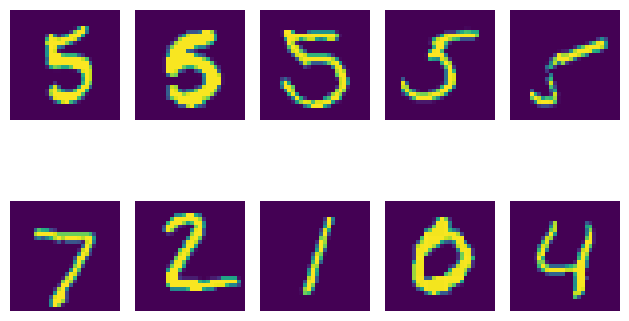

In [2]:
import math
from typing import TypeVar

import matplotlib.pyplot as plt
import numpy as np
import torch
from torchvision.datasets import MNIST
from torchvision import transforms
from torch.utils.data import ConcatDataset, DataLoader, Dataset, Subset, random_split
from torch import nn
from torch.nn import functional as F
from torch.nn.parameter import Parameter
from tqdm.notebook import tqdm

if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    print('WARNING: not using CUDA')


class MNISTDataSet(MNIST):
    def __init__(self, train: bool):
        super().__init__(
            '../.data',
            train=train,
            download=True,
            transform=transforms.ToTensor(),
        )

T = TypeVar('T')

def extract_single_target_class(dataset: Dataset[T], target, targets=None) -> tuple[Subset[T], Subset[T]]:
    """Returns a subset of dataset containing only samples with target class, and a subset containing all other samples."""
    indices = np.arange(len(dataset))
    mask = dataset.targets == target
    return Subset(dataset, indices[mask]), Subset(dataset, indices[~mask])

NORMAL_TARGET_CLASS = 5

testing_normal_set, testing_outlier_set = extract_single_target_class(
    MNISTDataSet(train=False), NORMAL_TARGET_CLASS
)
training_normal_set, training_outlier_set = extract_single_target_class(
    MNISTDataSet(train=True), NORMAL_TARGET_CLASS
)

# Further split the 'training' set into 2:1 ratio
training_set, testing_normal_set_from_training_set = random_split(
    training_normal_set, [2/3, 1/3]
)

testing_normal_set = ConcatDataset((testing_normal_set, testing_normal_set_from_training_set))
testing_outlier_set = ConcatDataset((testing_outlier_set, training_outlier_set))
testing_set = ConcatDataset((testing_normal_set, testing_outlier_set))

print(f'Training set (normal only):        {len(training_set)} samples')
print(f'Testing set (normal only):         {len(testing_normal_set)} samples')
print(f'Testing set (outliers only):       {len(testing_outlier_set)} samples')
print(f'Testing set (normal and outliers): {len(testing_set)} samples')
print(f'Total:                             {len(training_set) + len(testing_set)} samples')

training_loader = DataLoader(training_set, batch_size=32, shuffle=False)

# Show first 5 samples from training and testing outlier sets
axes = plt.subplots(2, 5)[1]
for ax, image in zip(axes[0], training_set):
    ax.imshow(image[0][0])
    ax.axis('off')
for ax, image in zip(axes[1], testing_outlier_set):
    ax.imshow(image[0][0])
    ax.axis('off')
plt.tight_layout()

In [3]:
class Encoder(nn.Module):
    def __init__(self):
        super().__init__()

        # Use the same encoder architecture as in the paper:
        conv_layers = [
            nn.Conv2d(1, 16, kernel_size=1, stride=2),
            nn.Conv2d(16, 32, kernel_size=3, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=2),
        ]

        modules = []
        for conv_layer in conv_layers:
            modules.extend((
                conv_layer,
                nn.BatchNorm2d(conv_layer.out_channels),
                nn.ReLU(),
            ))

        self.sequence = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequence(x)


class Decoder(nn.Module):
    def __init__(self):
        super().__init__()

        deconv_layers = [
            nn.ConvTranspose2d(64, 64, kernel_size=3, stride=2, output_padding=1),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2),
            nn.ConvTranspose2d(32, 1, kernel_size=3, stride=2, output_padding=1),
        ]

        modules = []
        for deconv_layer in deconv_layers[:-1]:
            modules.extend((
                deconv_layer,
                nn.BatchNorm2d(num_features=deconv_layer.out_channels),
                nn.ReLU(),
            ))

        modules.append(deconv_layers[-1])
        self.sequence = nn.Sequential(*modules)

    def forward(self, x):
        return self.sequence(x)


class AutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        return self.decoder(self.encoder(x))


def hard_shrink_relu(input, lambd=0, epsilon=1e-12):
    output = (F.relu(input-lambd) * input) / (torch.abs(input - lambd) + epsilon)
    return output


class MemoryUnit(nn.Module):
    """From https://github.com/YUL-git/MemAE"""
    def __init__(self, mem_dim, fea_dim, shrink_thres):
        super().__init__()
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim
        self.weight = Parameter(torch.Tensor(self.mem_dim, self.fea_dim)) # N x C
        self.shrink_thres = shrink_thres
        self.reset_parameters()

    def reset_parameters(self):
        stdv = 1. / math.sqrt(self.weight.size(1))
        self.weight.data.uniform_(-stdv, stdv)

    def forward(self, x):
        att_weight = F.linear(x, self.weight)  # Fea x Mem^T, (TxC) x (CxN) = TxN
        att_weight = F.softmax(att_weight, dim=1)  # TxN , 논문에선 1xN

        if self.shrink_thres > 0:
            att_weight = hard_shrink_relu(att_weight, lambd=self.shrink_thres)
            att_weight = F.normalize(att_weight, p=1, dim=1) # Re-normalize, TxN

        mem_trans = self.weight.permute(1, 0)  # Mem^T, CxN
        output = F.linear(att_weight, mem_trans)  # AttWeight x Mem^T^T = AW x Mem, (TxN) x (NxC) = TxC
        return {'output': output, 'att': att_weight}  # output, att_weight


# NxCxHxW -> (NxHxW)xC -> addressing Mem, (NxHxW)xC -> NxCxHxW
class MemModule(nn.Module):
    """From https://github.com/YUL-git/MemAE"""
    def __init__(self, mem_dim, fea_dim, shrink_thres=0.0025):
        super().__init__()
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim
        self.shrink_thres = shrink_thres
        self.memory = MemoryUnit(self.mem_dim, self.fea_dim, self.shrink_thres)

    def forward(self, x):
        batch, channel, row, col = x.shape
        x = x.permute(0, 2, 3, 1) # (B, row, col, channel)
        x = x.contiguous()
        x = x.view(-1, channel) # (B x row x col, channel)

        y_and = self.memory(x)
        y = y_and['output']
        att = y_and['att']

        y = y.view(batch, row, col, channel)
        y = y.permute(0, 3, 1, 2) # (B, channel, row, col)
        att = att.view(batch, row, col, self.mem_dim)
        att = att.permute(0, 3, 1, 2)

        return {'output': y, 'att': att}


class MemoryAugmentedAutoEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

        # Paper uses a memory size of 100 for MNIST
        self.memory_module = MemModule(mem_dim=100, fea_dim=64)

    def forward(self, x):
        mem = self.memory_module(self.encoder(x))
        return {
            'output': self.decoder(mem['output']),
            'att': mem['att'],
        }


class EntropyLoss(nn.Module):
    def __init__(self, eps = 1e-12):
        super().__init__()
        self.eps = eps

    def forward(self, x):
        b = x * torch.log(x + self.eps)
        b = -1.0 * b.sum(dim=1)
        b = b.mean()
        return b


# According to paper, alpha = 0.0002 led to desirable results in all experiments
class MSEEntropyLoss(nn.Module):
    def __init__(self, alpha: float = 0.0002):
        super().__init__()
        self.alpha = alpha
        self.mse = nn.MSELoss()
        self.entropy_loss = EntropyLoss()

    def forward(self, output, target):
        reconstruction_loss = self.mse(output['output'], target)
        entropy_loss = self.entropy_loss(output['att'])
        return reconstruction_loss + self.alpha * entropy_loss


display(AutoEncoder())
display(MemoryAugmentedAutoEncoder())

AutoEncoder(
  (encoder): Encoder(
    (sequence): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
  )
  (decoder): Decoder(
    (sequence): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

MemoryAugmentedAutoEncoder(
  (encoder): Encoder(
    (sequence): Sequential(
      (0): Conv2d(1, 16, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU()
      (6): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
      (7): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (8): ReLU()
    )
  )
  (decoder): Decoder(
    (sequence): Sequential(
      (0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(2, 2), output_padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): ConvTranspose2d(64, 32, kernel_size=(3, 3), stride=(2, 2))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_st

In [4]:
class ModelTrainer:
    def __init__(
        self, *,
        model: nn.Module,
        dataloader: DataLoader,
        loss_fn: nn.Module,
        optimizer: torch.optim.Optimizer,
        num_epoch: int,
    ):
        self.model = model
        self.dataloader = dataloader
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.num_epoch = num_epoch

    def train(self) -> nn.Module:
        self.model.train(True)
        with tqdm(
            range(self.num_epoch),
            total=self.num_epoch,
            desc='Training',
            unit='epoch',
        ) as pbar:
            for epoch in pbar:
                avg_loss = self._train_one_epoch(epoch, self.num_epoch)
                pbar.set_postfix({'Avg. loss': avg_loss})

        return self.model

    def _train_one_epoch(self, epoch_index, num_epoch):
            # Adapted for autoencoder from:
            # https://pytorch.org/tutorials/beginner/introyt/trainingyt.html

            training_loss = 0
            with tqdm(
                self.dataloader,
                desc=f'Epoch {epoch_index + 1}/{num_epoch}',
                unit='batch',
                leave=False,
            ) as pbar:
                for data, _ in pbar:
                    data = data.to(device) # not sure if this is the best way to do this?
                    reconstructed = self.model(data)
                    loss = self.loss_fn(reconstructed, data)

                    self.optimizer.zero_grad()
                    loss.backward()
                    self.optimizer.step()

                    training_loss += loss.item()
                    pbar.set_postfix({'Loss': loss.item()})

            return training_loss / len(self.dataloader)

ae_model = AutoEncoder().to(device)
ae_model = ModelTrainer(
    model=ae_model,
    dataloader=training_loader,
    loss_fn=nn.MSELoss(),
    optimizer=torch.optim.Adam(ae_model.parameters(), lr=0.0001),
    num_epoch=60,
).train()

memae_model = MemoryAugmentedAutoEncoder().to(device)
memae_model = ModelTrainer(
    model=memae_model,
    dataloader=training_loader,
    loss_fn=MSEEntropyLoss(),
    optimizer=torch.optim.Adam(memae_model.parameters(), lr=0.0001),
    num_epoch=60,
).train()

Training:   0%|          | 0/60 [00:00<?, ?epoch/s]

Epoch 1/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 2/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 3/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 4/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 5/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 6/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 7/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 8/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 9/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 10/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 11/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 12/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 13/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 14/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 15/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 16/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 17/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 18/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 19/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 20/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 21/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 22/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 23/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 24/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 25/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 26/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 27/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 28/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 29/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 30/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 31/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 32/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 33/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 34/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 35/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 36/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 37/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 38/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 39/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 40/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 41/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 42/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 43/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 44/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 45/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 46/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 47/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 48/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 49/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 50/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 51/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 52/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 53/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 54/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 55/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 56/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 57/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 58/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 59/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 60/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Training:   0%|          | 0/60 [00:00<?, ?epoch/s]

Epoch 1/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 2/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 3/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 4/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 5/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 6/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 7/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 8/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 9/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 10/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 11/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 12/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 13/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 14/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 15/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 16/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 17/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 18/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 19/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 20/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 21/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 22/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 23/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 24/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 25/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 26/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 27/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 28/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 29/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 30/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 31/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 32/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 33/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 34/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 35/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 36/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 37/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 38/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 39/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 40/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 41/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 42/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 43/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 44/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 45/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 46/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 47/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 48/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 49/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 50/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 51/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 52/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 53/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 54/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 55/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 56/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 57/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 58/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 59/60:   0%|          | 0/113 [00:00<?, ?batch/s]

Epoch 60/60:   0%|          | 0/113 [00:00<?, ?batch/s]

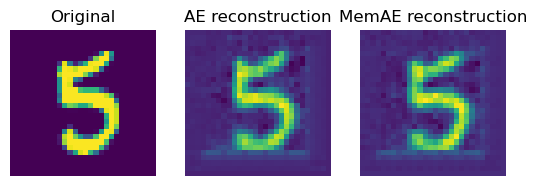

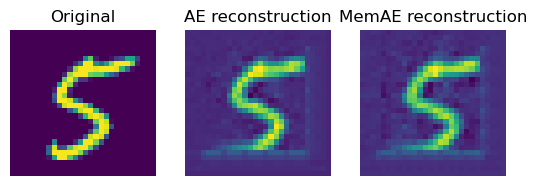

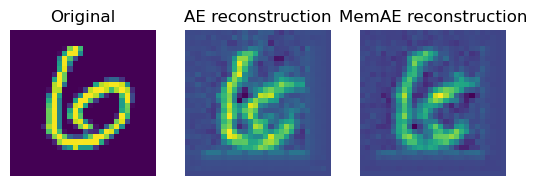

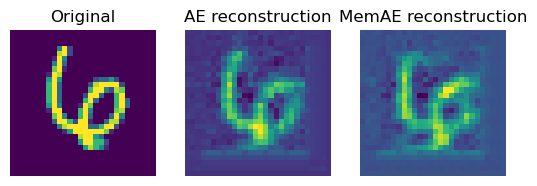

In [5]:
class ItemGetter(nn.Module):
    def __init__(self, key):
        super().__init__()
        self.key = key

    def forward(self, x):
        return x[self.key]

memae_model_output = nn.Sequential(memae_model, ItemGetter('output'))

def plot_reconstruction(image):
    ae_model.eval()
    memae_model_output.eval()

    image = torch.unsqueeze(image, 0)
    with torch.no_grad():
        ae_recon = ae_model(image.to(device))
        memae_recon = memae_model_output(image.to(device))

    fig, axes = plt.subplots(1, 3)
    axes[0].imshow(image[0][0])
    axes[0].set_title('Original')
    axes[1].imshow(ae_recon[0][0].cpu().numpy())
    axes[1].set_title('AE reconstruction')
    axes[2].imshow(memae_recon[0][0].cpu().numpy())
    axes[2].set_title('MemAE reconstruction')

    for ax in axes:
        ax.axis('off')

plot_reconstruction(training_set[0][0])
plot_reconstruction(testing_normal_set[10][0])
plot_reconstruction(testing_outlier_set[10][0])
plot_reconstruction(testing_outlier_set[20][0])


In [6]:
def validate_model(model):
    y_score = []
    y_true = []
    model.eval()
    testing_loader = DataLoader(testing_set, batch_size=256)
    for data, target in tqdm(testing_loader, total=len(testing_loader), unit='batch'):
        data = data.to(device)
        with torch.no_grad():
            recon = model(data)
            true = (target == NORMAL_TARGET_CLASS).cpu().numpy().astype(int)

            # Lower MSE = higher score, so negate the value
            score = -((recon - data)**2).mean(dim=(1, 2, 3)).cpu().numpy()

        y_true.extend(true)
        y_score.extend(score)

    return np.asarray(y_true), np.asarray(y_score)

ae_y_true, ae_y_score = validate_model(ae_model)
memae_y_true, memae_y_score = validate_model(memae_model_output)

  0%|          | 0/260 [00:00<?, ?batch/s]

  0%|          | 0/260 [00:00<?, ?batch/s]

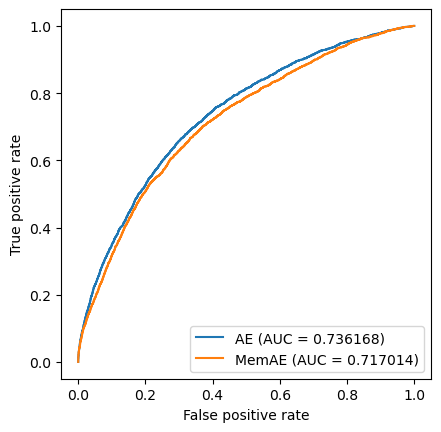

In [7]:
from sklearn.metrics import roc_auc_score, roc_curve

def plot_roc(y_true, y_score, name):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:g})')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

plot_roc(ae_y_true, ae_y_score, 'AE')
plot_roc(memae_y_true, memae_y_score, 'MemAE')
plt.legend()
plt.gca().set_aspect(1)